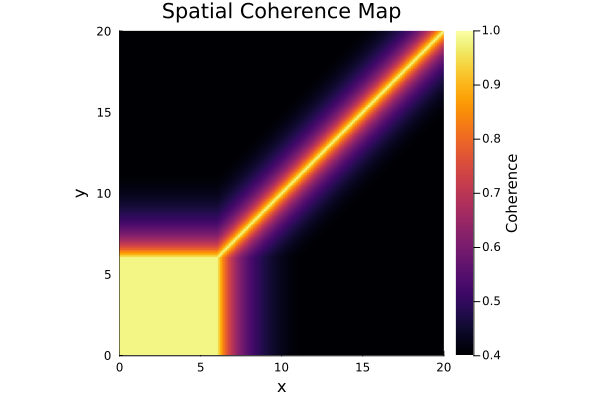

In [ ]:
using Plots

# Parameters
λ = 1.0                     # Wavelength
nat = 1.0 / λ^3            # Atomic density
rb = 6.0 * λ               # Blockade radius


# Grid
x_vals = range(0, stop=20.0, length=500)
y_vals = range(0, stop=20.0, length=500)
Z = zeros(length(x_vals), length(y_vals))

# Function definition
function coherence(x, y, λ, nat, rb)
    δ = abs(x - y)
    if x > rb && y > rb
        L=exp(- (3/2π) * δ / λ * nat * λ^3)
    elseif x < rb && y < rb
        L=1
    elseif x <= rb
        #L=exp(- (3/(4π)) * δ / λ * nat * λ^3 - (3/(4π)) * (y - rb) / λ * nat * λ^3)
        L=exp(- (3/(2π)) * (y - rb) / λ * nat * λ^3)
    else # y <= rb
        #L=exp(- (3/(4π)) * δ / λ * nat * λ^3- (3/(4π)) * (x - rb) / λ * nat * λ^3)
        L=exp(- (3/(2π)) * (x - rb) / λ * nat * λ^3)
    end
    return L=exp(-1) *(1+L+1/2*L^2+1/6*L^3)
end


# Compute values
for (i, x) in enumerate(x_vals)
    for (j, y) in enumerate(y_vals)
        Z[i, j] = coherence(x, y, λ, nat, rb)
    end
end

# Plot
heatmap(x_vals, y_vals, Z',
    xlabel="x",
    ylabel="y",
    colorbar_title="Coherence",
    title="Spatial Coherence Map",
    aspect_ratio=:equal, xlims=(0,20), clims=(0.4, 1.0),
    c=:inferno)


In [4]:
savefig("MB_density_matrix.svg")

"c:\\Users\\tkaranikolaou\\OneDrive - ICFO\\decoherence_scattering\\nagazima\\spin_wave_full\\data_spin_wave_full\\real_gaussian_beam\\MB\\MB_density_matrix.svg"

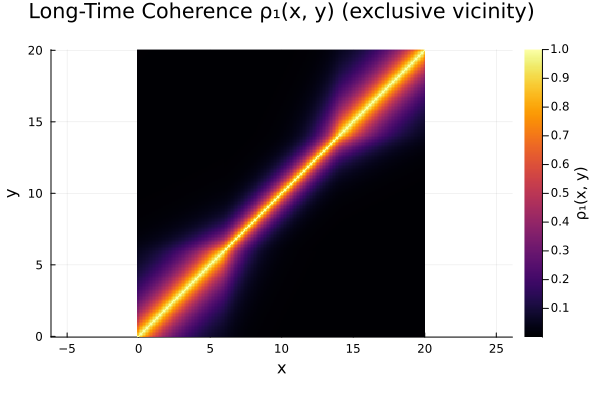

In [37]:
using Plots

# Parameters
rb = 0.3 *20                     # blockade radius
L = 20.0                     # total length of the system
db = 6.0                     # d_b
                  # z_b
ρ₀ = 1.0                     # initial coherence

# Grid
x_vals = range(0, stop=L, length=200)
y_vals = range(0, stop=L, length=200)
Z = zeros(length(x_vals), length(y_vals))

# Updated f(z; x, y): 1 only if z is in vicinity of exactly one of x or y
function f(z, x, y, rb)
    dx = abs(z - x) < rb
    dy = abs(z - y) < rb
    return (dx ⊻ dy) ? 1.0 : 0.0  # logical XOR: true if exactly one is true
end

# Trapezoidal integration
function trapz_integral(f_vals, dz)
    return sum(f_vals[2:end-1]) + 0.5*(f_vals[1] + f_vals[end])
end

# Main function rho1(x, y)
function rho1(x, y, rb, db,  L, ρ₀)
    dz = 0.1
    zs = 0:dz:L
    integrand = zeros(length(zs))

    for (i, z) in enumerate(zs)
        xprimes = 0:dz:z
        f_inner = [f(xp, x, y, rb) for xp in xprimes]
        inner_integral = trapz_integral(f_inner, dz) * dz
        integrand[i] = f(z, x, y, rb) * exp(- (db / (2rb)) * inner_integral)
    end

    outer_integral = trapz_integral(integrand, dz) * dz
    return (1 - (db / (2rb)) * outer_integral) * ρ₀
end

# Populate the matrix
for (i, x) in enumerate(x_vals)
    for (j, y) in enumerate(y_vals)
        Z[i, j] = rho1(x, y, rb, db,  L, ρ₀)
    end
end

# Plot
heatmap(x_vals, y_vals, Z',
    xlabel="x",
    ylabel="y",
    colorbar_title="ρ₁(x, y)",
    title="Long-Time Coherence ρ₁(x, y) (exclusive vicinity)",
    aspect_ratio=1,
    c=:inferno)

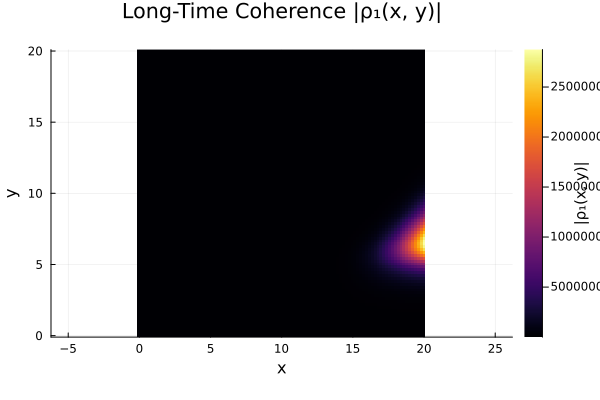

In [44]:
using Plots

# Parameters
db = 10.0
zb = 6.0
L = 20.0
ρ₀ = 1.0
dz = 0.1

# Grids
x_vals = range(0, stop=L, length=100)
y_vals = range(0, stop=L, length=100)
Z = zeros(ComplexF64, length(x_vals), length(y_vals))

# Trapezoidal integration
function trapz_integral(f_vals, dz)
    return dz * (sum(f_vals[2:end-1]) + 0.5 * (f_vals[1] + f_vals[end]))
end

# Define ρ₁(x, y)
function rho1(x, y, db, zb, L, dz, ρ₀)
    zs = 0:dz:L
    integrand = ComplexF64[]
    for z in zs
        # Inner integral over z'
        z_primes = 0:dz:z
        f_inner = [zb^6 / (zb^6 + im*(z′ - x)^6) - zb^6 / (zb^6 - im*(z′ - y)^6) for z′ in z_primes]
        inner = trapz_integral(f_inner, dz)

        # Outer integrand
        numerator = zb^6 * ((z - y)^6 - (z - x)^6)
        denominator = (zb^6 + im*(z - x)^6) * (zb^6 - im*(z - y)^6)
        push!(integrand, numerator / denominator * exp(-db / zb * inner))
    end

    outer = trapz_integral(integrand, dz)
    return ρ₀ * (1 - db / zb * outer)
end

# Fill matrix
for (i, x) in enumerate(x_vals)
    for (j, y) in enumerate(y_vals)
        Z[i, j] = rho1(x, y, db, zb, L, dz, ρ₀)
    end
end

# Plot |ρ₁(x, y)|
heatmap(x_vals, y_vals, abs.(Z)',
    xlabel="x",
    ylabel="y",
    colorbar_title="|ρ₁(x, y)|",
    title="Long-Time Coherence |ρ₁(x, y)|",
    aspect_ratio=1,
    c=:inferno)
